# Testing DeepER

### Import libraries

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys
sys.path.append('../')

In [1]:
import time
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
import seaborn as sns
from deeper_model import build_model
from deeper_utils import preprocess_data

Using TensorFlow backend.


### Read the dataset

In [2]:
trainData, testData, valData, embeddingMatrix, wordsWithNoEmbeddings = preprocess_data(
    'DBLP-Scholar', baseDir = '..', maxSequenceLength=100)

Printing out words with no embeddings in GloVe

In [3]:
PRINT_RANGE = 30

if len(wordsWithNoEmbeddings) < PRINT_RANGE:
    PRINT_RANGE = len(wordsWithNoEmbeddings)

if PRINT_RANGE > 0:   
    for i in range(PRINT_RANGE):
        print(wordsWithNoEmbeddings[i])

print('...')
print("There are {} words with no embeddings in GloVe".format(len(wordsWithNoEmbeddings)))

sigmod
vldb
srikant
ramakrishnan
seshadri
suciu
kriegel
abiteboul
haritsa
lakshmanan
hellerstein
florescu
stonebraker
livny
papakonstantinou
faloutsos
ioannidis
garofalakis
gehrke
pirahesh
acms
ramamritham
bertino
roussopoulos
poosala
silberschatz
navathe
kossmann
subrahmanian
shekita
...
There are 5915 words with no embeddings in GloVe


Print embedding matrix shape

In [4]:
embeddingMatrix.shape

(15423, 300)

In [5]:
leftTableTrainData, rightTableTrainData, trainLabels = trainData
leftTableTestData, rightTableTestData, testLabels = testData
leftTableValData, rightTableValData, valLabels = valData

Print training set size

In [6]:
print(leftTableTrainData.shape)
print(rightTableTrainData.shape)

(17223, 100)
(17223, 100)


Print test set size

In [7]:
print(leftTableTestData.shape)
print(rightTableTestData.shape)

(5742, 100)
(5742, 100)


Print validation set size

In [8]:
print(leftTableValData.shape)
print(rightTableValData.shape)

(5742, 100)
(5742, 100)


### Build the DeepER model 

In [9]:
model = build_model(embeddingMatrix, lstmUnits=75, denseUnits=[16, 8], lstm_dropout=0.1, mask_zero=True, maxSequenceLength=100)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     4626900     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 150)          225600      embedding_1[0][0]                
          

### Plot DeepER architecture

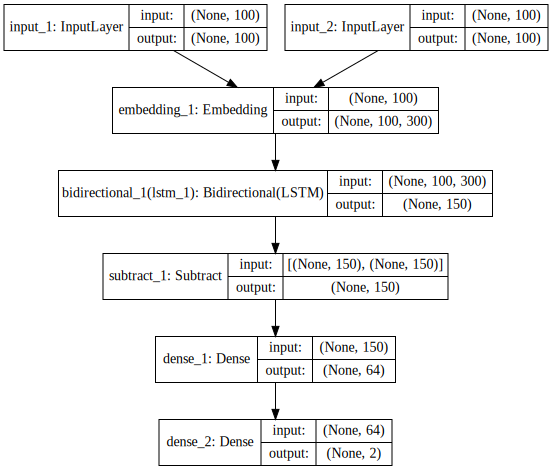

In [10]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Training

In [11]:
start_time = time.time()

history = model.fit([leftTableTrainData,
           rightTableTrainData],
          trainLabels,
          batch_size=16,
          epochs=20,
          validation_data=([leftTableValData,
                            rightTableValData],
                           valLabels))

elapsed_time = time.time() - start_time
t = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print('Elapsed time (learning):', t)

Train on 17223 samples, validate on 5742 samples
Epoch 1/20
17223/17223 [==============================] - 66s 4ms/step - loss: 0.3877 - acc: 0.8209 - val_loss: 0.2487 - val_acc: 0.9068
Epoch 2/20
17223/17223 [==============================] - 62s 4ms/step - loss: 0.1942 - acc: 0.9275 - val_loss: 0.1680 - val_acc: 0.9354
Epoch 3/20
17223/17223 [==============================] - 61s 4ms/step - loss: 0.1106 - acc: 0.9641 - val_loss: 0.1451 - val_acc: 0.9450
Epoch 4/20
17223/17223 [==============================] - 61s 4ms/step - loss: 0.0669 - acc: 0.9786 - val_loss: 0.1639 - val_acc: 0.9415
Epoch 5/20
17223/17223 [==============================] - 61s 4ms/step - loss: 0.0430 - acc: 0.9865 - val_loss: 0.1411 - val_acc: 0.9502
Epoch 6/20
17223/17223 [==============================] - 61s 4ms/step - loss: 0.0261 - acc: 0.9932 - val_loss: 0.1533 - val_acc: 0.9462
Epoch 7/20
17223/17223 [==============================] - 61s 4ms/step - loss: 0.0189 - acc: 0.9950 - val_loss: 0.1512 - val_acc:

### Plot accuracy and loss

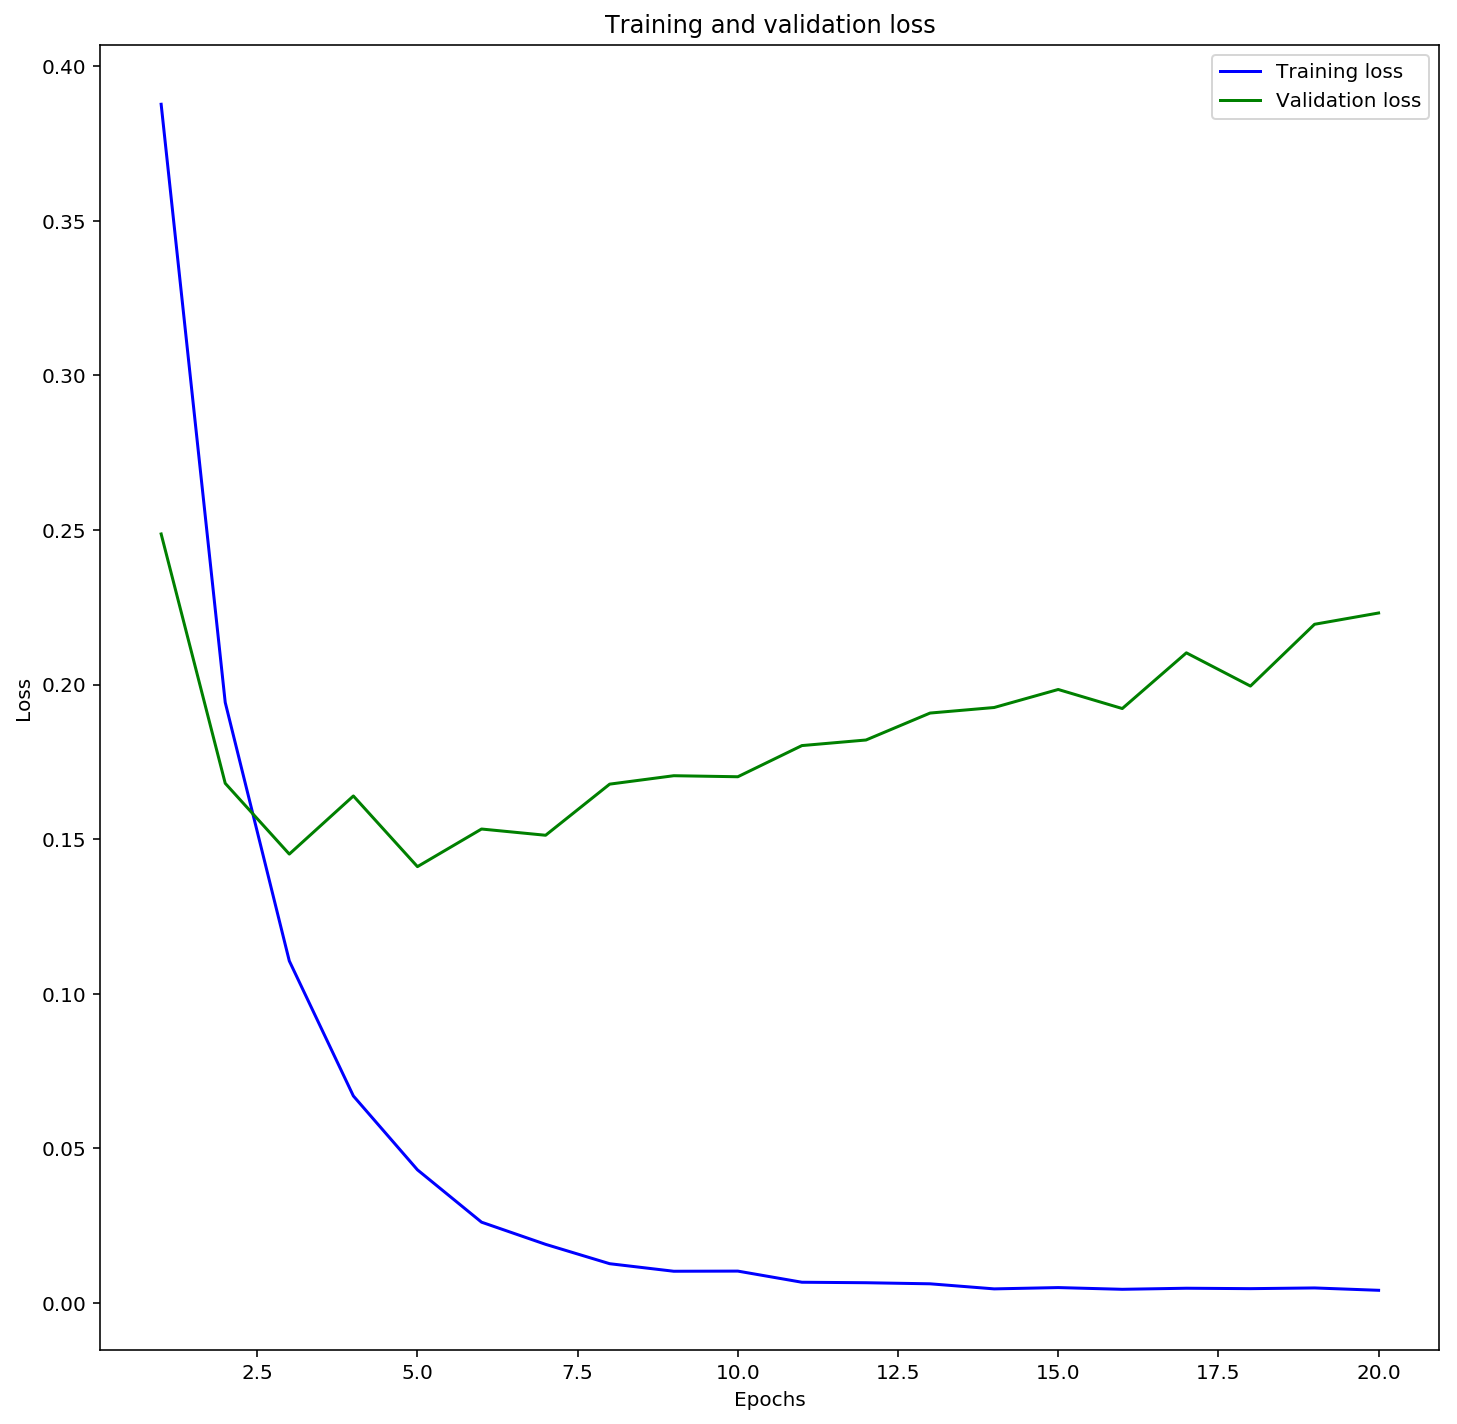

In [12]:
history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,12))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

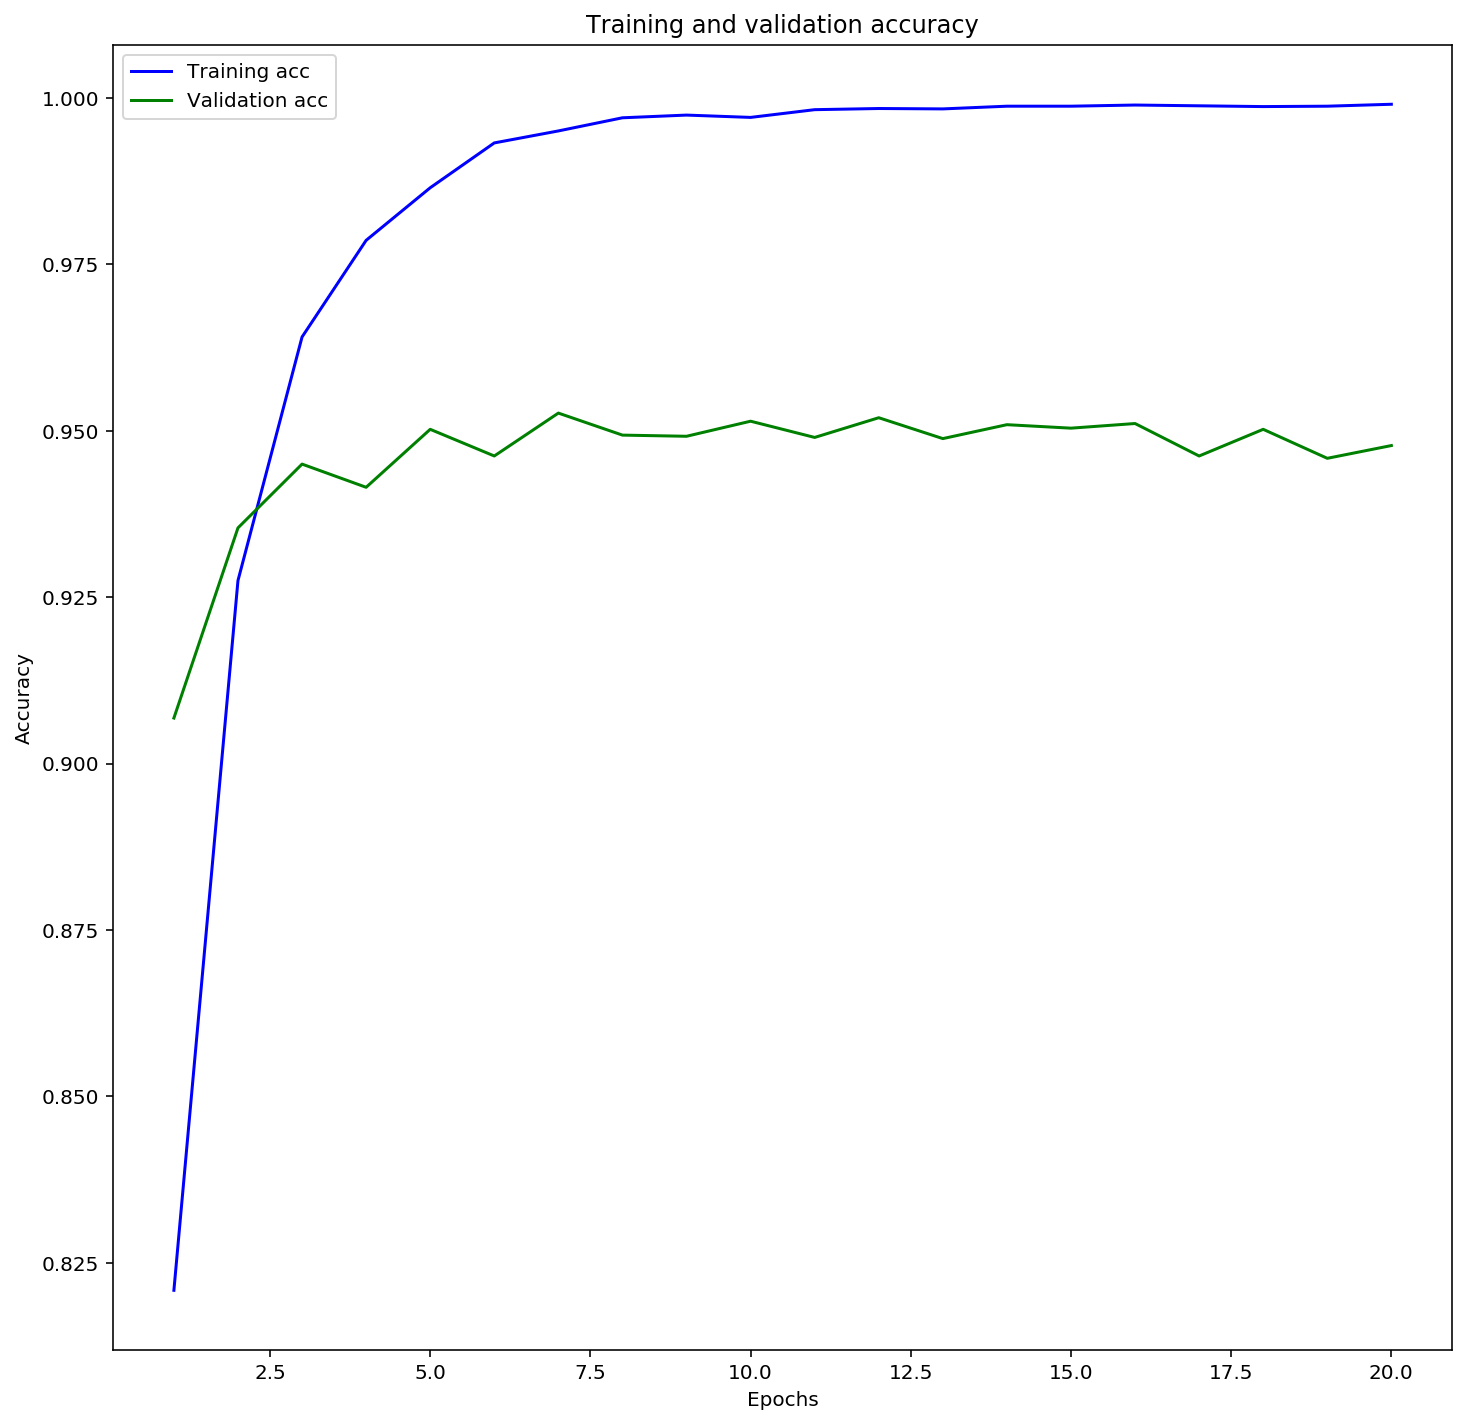

In [13]:
plt.figure(figsize=(12,12))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### Predict labels on test data

In [14]:
predictedLabels = model.predict(x=[leftTableTestData, rightTableTestData])
predictedBinaryLabels = predictedLabels.argmax(axis=1)
testBinaryLabels = testLabels.argmax(axis=1)

### Compute confusion matrix

[Text(0, 0.5, 'non matching'), Text(0, 1.5, 'matching')]

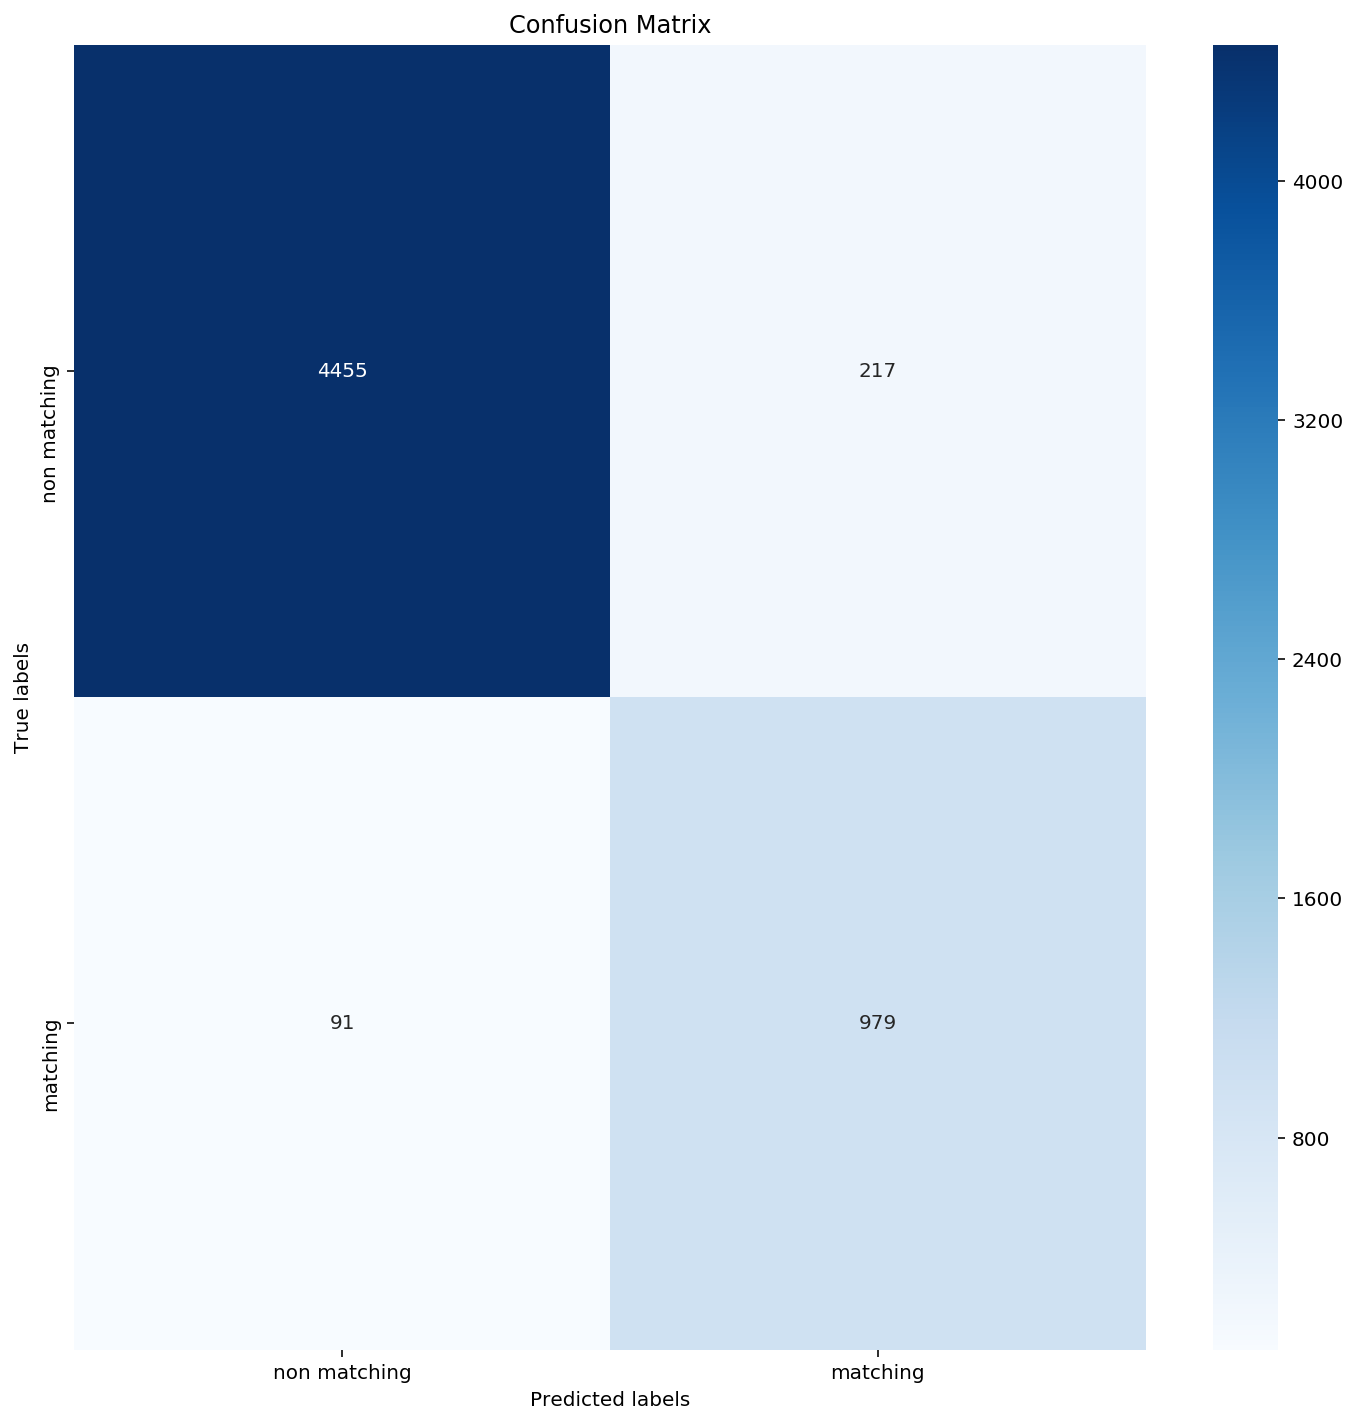

In [15]:
cm = confusion_matrix(testBinaryLabels, predictedBinaryLabels)
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['non matching', 'matching'])
ax.yaxis.set_ticklabels(['non matching', 'matching'])

### Compute metrics

In [16]:
precision, recall, fMeasure, support = precision_recall_fscore_support(testBinaryLabels, predictedBinaryLabels, average='binary')

if fMeasure is None:
    fMeasure = 0.0
if support is None:
    support = 0.0

row_format ="{:>15}" * 4
print(row_format.format('Precision', 'Recall', 'F-measure', 'Support'))
print(row_format.format(round(precision, 2), round(recall, 2), round(fMeasure,2), round(support, 2)))

      Precision         Recall      F-measure        Support
           0.82           0.91           0.86            0.0
